<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>"Глубокое обучение". Продвинутый поток</b></h3>

<h2 style="text-align: center;"><b>Семинар 7. PyTorch. Батчнорм и дропаут. </b></h2>


In [1]:
import os

import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils, datasets

sns.set(font_scale=1.4, style="whitegrid")

In [2]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
device

device(type='cuda')

# Загрузка датасета


In [3]:
classes = ("plane", "car", "bird", "cat",
           "deer", "dog", "frog", "horse", "ship", "truck")

def get_dataloaders(batch_size):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    trainset = datasets.CIFAR10(root="./data", train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    testset = datasets.CIFAR10(root="./data", train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader

В PyTorch датасетом считается любой объект, для которого определены методы `__len__(self)` и `__getitem__(self, i)`.

# Код обучения

In [18]:
# def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
#   train_losses = []
#   val_losses = []
#   val_accuracies = []
#   for epoch in tqdm(range(epochs)):
#     model.train()
#     loss_sum = 0
#     for xb,yb in tqdm(train_dl):
#       xb, yb = xb.to(device), yb.to(device)

#       loss = loss_func(model(xb), yb)
#       loss_sum += loss.item()
      
#       loss.backward()
#       opt.step()
#       opt.zero_grad()
#     train_losses.append(loss_sum / len(train_dl))

#     model.eval()
#     loss_sum = 0
#     correct = 0
#     num = 0
#     with torch.no_grad():
#       for xb,yb in tqdm(valid_dl):
#         xb, yb = xb.to(device), yb.to(device)

#         porbs = model(xb)
#         loss_loss_sum += loss_func(probs, yb).item()

#         _, pred = torch.max(probs, axis=-1)
#         correct += (preds == yb).sum().item()
#         num += len(xb)

#     val_losses.append(loss_sum / len(valid_dl))
#     val_accuracies.append(correct / num)

#   return train_losses, val_losses, val_accuracies

In [24]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for xb, yb in tqdm(train_dl):
            xb, yb = xb.to(device), yb.to(device)
            
            loss = loss_func(model(xb), yb)
            loss_sum += loss.item()
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for xb, yb in tqdm(valid_dl):
                xb, yb = xb.to(device), yb.to(device)
                
                probs = model(xb)
                loss_sum += loss_func(probs, yb).item()
                
                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)
                
        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(correct / num)
        
    return train_losses, val_losses, valid_accuracies

In [8]:
def plot_trainig(train_losses, valid_losses, valid_accuracies):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

In [34]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.fc1 = nn.Linear(6 * 16 * 6, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(x.shape[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [26]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

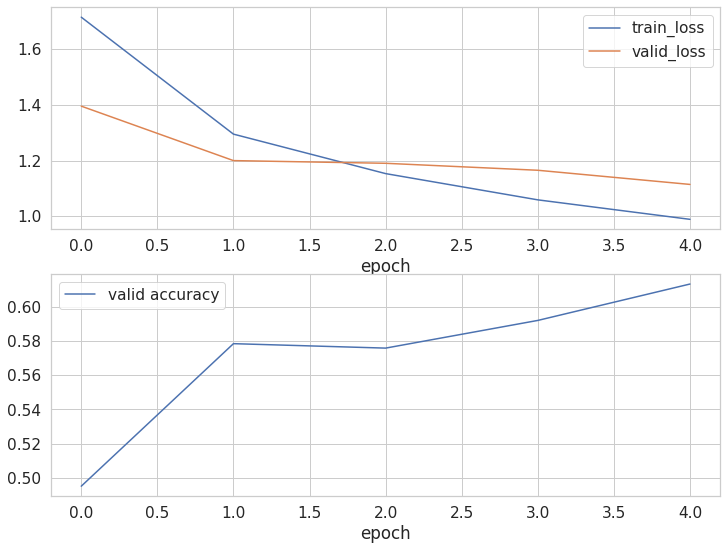

In [27]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

info = fit(5, model, criterion, optimizer, *get_dataloaders(4))
plot_trainig(*info)

# BatchNorm
Ранее мы обсуждали, что для линейных моделей очень важно нормировать признаки перед подачей на вход. Когда мы работаем с нейронными сетями мы тоже нормируем вход, но есть ли какой-то способ нормировать признаки на внутренних слоях нейроной сети?

Да, существует несколько метдов нормировки признаков (BatchNorm, LayerNorm, InstanceNorm, etc). Научимся применять BatchNorm.


### BatchNorm, математика

Если коротко, то BatchNorm для каждого признака вычитает среднее значение по батчу и делит на стандартное отклонение по батчу, потом домножает все признаки на вес $\gamma$ и прибавляет вес $\beta$. При этом возникает вопрос, что если мы используем модель уже для предсказаний и можем запускать ее только на одном примере.

BatchNorm работает по разному во время обучения и предсказний:


**Во время обучения**. Пусть батч состоит из $\mathbf{x_i}$ (каждый $\mathbf{x_i}$ - вектор, подающийся на вход). Тогда
$$\begin{aligned}
\mu_{\mathcal{B}} & \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_{i} \\
\sigma_{\mathcal{B}}^{2} & \leftarrow \frac{1}{m} \sum_{i=1}^{m}\left(x_{i}-\mu_{\mathcal{B}}\right)^{2} \\
\widehat{x}_{i} & \leftarrow \frac{x_{i}-\mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^{2}+\epsilon}} \\
y_{i} & \leftarrow \gamma \widehat{x}_{i}+\beta \equiv \mathrm{B} \mathrm{N}_{\gamma, \beta}\left(x_{i}\right)
\end{aligned}$$

**Во время предсказания**. Мы делаем то же самое, но у нас нет батча. Поэтому в качестве $\mu_{\mathcal{B}}$ и $\sigma_{\mathcal{B}}$ мы используем среднее и стандартное отклонение признака во всем датасете. Обычно нам не хочется после обучения еще раз применять сеть ко всем примерам из обучающего датасета, чтобы вычислить эти статистики и мы вместо них используем экспоненциально затухающее среднее последних батчей.

### BatchNorm, что он дает?

* Более быстрое обучение. Болшие learning_rate"ы.
* Обучение более глубоких сетей.
* Регуляризация.
* Повышение точности моделей.

### BatchNorm для Conv слоев

Для сверточных слоев мы хотим следующее свойство "если в разных частях картинки находятся одинаковые наборы пикселей, то соответствующие выходы сверточного слоя будут одинаковыми". Если бы мы применяли алгоритм, который описан выше, то получилось бы так, что для пикселей, находящихся в 1 канале в координате (1,1) среднее и стд могли бы получиться не такими же как для пикселя в 1 канале в координате (10, 10). Тогда даже если изначально в них были одинаковые значения, то после BatchNorm они стали бы разными. 

Есть простое решение проблемы. Мы будем усреднять не только по batch_size координате, но и height, width координатам. Чтобы лучше объяснить используем псевдокод (origin https://stackoverflow.com/questions/38553927/batch-normalization-in-convolutional-neural-network):

На вход подается тензор (многомерный массив) размера [B, H, W, C]. Где B - количество батчей, H - высота картинок, W - ширина картинок, а C - количество каналов. Тогда обычный батчнорм выполнял бы нормирование так:
```python
# t is the incoming tensor of shape [B, H, W, C]
# mean and stddev are computed along 0 axis and have shape [H, W, C]
mean = mean(t, axis=0)
stddev = stddev(t, axis=0)
for i in 0..B-1:
  out[i,:,:,:] = norm(t[i,:,:,:], mean, stddev)
```

В то время как батчнорм для сверточных сетей (BatchNorm2D в PyTorch):

```python
# t is still the incoming tensor of shape [B, H, W, C]
# but mean and stddev are computed along (0, 1, 2) axes and have just [C] shape
mean = mean(t, axis=(0, 1, 2))
stddev = stddev(t, axis=(0, 1, 2))
for i in 0..B-1, x in 0..H-1, y in 0..W-1:
  out[i,x,y,:] = norm(t[i,x,y,:], mean, stddev)
```

### BatchNorm, порядок применения

В оригинальной статье (http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43442.pdf) для сверточных слоев батчнорм предлагают использовать сразу после свертки до активации. Я не смог найти статей, которые бы исследовали, нужно ли делать BN до или после активации, и, похоже, однозначного мнения нет + в более сложных архитектурах (ResNet"ы) исследователи обычно экспериментируют и ставят BN в разные места.

### BatchNorm, PyTorch

In [33]:
class MyBatchNormModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 3)
    self.bn1 = nn.BatchNorm2d(6)
    self.conv2 = nn.Conv2d(6, 16, 3)
    self.bn2 = nn.BatchNorm2d(16)
    self.fc1 = nn.Linear(6 * 16 * 6, 120)
    self.bn3 = nn.BatchNorm1d(120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.bn1(F.max_pool2d(F.relu(self.conv1(x)), (2, 2)))
    x = self.bn2(F.max_pool2d(F.relu(self.conv2(x)), 2))
    x = x.view(x.shape[0], -1)
    x = self.bn3(F.relu(self.fc1(x)))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
class ModelBatchNorm(nn.Module):
    def __init__(self):
        super(ModelBatchNorm, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.bn1(F.max_pool2d(F.relu(self.conv1(x)), (2, 2)))
        x = self.bn2(F.max_pool2d(F.relu(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = self.bn3(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

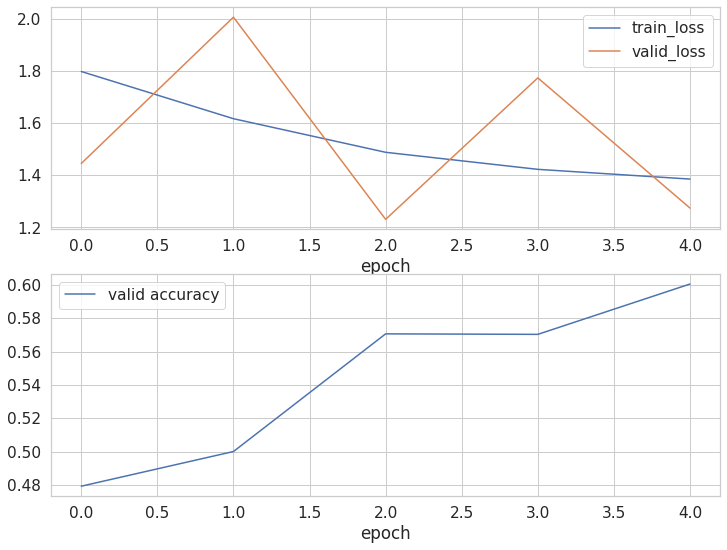

In [35]:
model = MyBatchNormModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

info = fit(5, model, criterion, optimizer, *get_dataloaders(4))
plot_trainig(*info)

Вспомните как выглядели формулы для BatchNorm: если размер батча равен 1, то $\sigma = 0$, и у нас есть деление на ноль. PyTorch не умеет обрабатывать такой случай и падает:

In [39]:
model = MyBatchNormModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

fit(1, model, criterion, optimizer, *get_dataloaders(batch_size=1))

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/50000 [00:00<?, ?it/s]

ValueError: ignored

# Dropout

Дропаут это еще один необычный слой, который используется в нейронных сетях. У него есть один гиперпараметр $p$.

Идея дропаута состоит в том, что во время обучения мы зануляем случайную часть входа и отдаем вход дальше (для каждого числа мы подбрасываем монетку и с вероятностью $p$ зануляем это число). 

Дропаут позволяет тренировать более устойчивые сети и избегать переобучения. 

### Dropout, механика работы.

Как мы сказали выше, dropout зануляет случайную часть входов и отдает их дальше. Допустим $p=0.5$ (достаточное популярное значение). Тогда мы просто убираем половину всего входа! Такое сильное воздействие явно плохо повлияет на качество нашей модели, поэтому мы делаем зануление только во время обучения.

**Во время обучения**: для каждого числа во входе подбрасываем монетку и зануляем его с вероятностью $p$. Выход умножаем на $\frac{1}{1-p}$, чтобы дисперсия выходов осталось такой же, как и на входе.

**Во время предсказаний**: ничего не делаем).

### Dropout, что дает?

* Сеть выучивает более устойчивые представления на внутренних слоях.
* Сильно увеличивает число итераций, которые нужны для сходимости.
* Можно получить интерпретацию, которая говорит, что дропаут усредняет выходы большо числа нейросетей с $p|W|$ нейронами на предыдущем слоев. 

Дропаут вызывает интересный эффект: в начале обучения качество на тестовом датасете выше, чем на обучающем. Потому что для обучающего датасета у нас есть зануление, которое сильно портит предсказания.

### Dropout, взаимодействие с BatchNorm.

Статья, исследующая, почему исопльзование дропаута и батчнорма вместе часто ведет к более плохим результатам, чем их использование по-отдельности - https://arxiv.org/pdf/1801.05134.pdf

Картинка из статьи, объясняющая проблему:
![img](https://media.arxiv-vanity.com/render-output/3934414/x1.png)

(Если совсем коротко, то при наличии дропаута во время обучения и во время предсказаний выходы дропаута имеют разное распределение. Поэтому статистики, которые batchnorm считает для применения во время предсказаний, оказываются неверными.)

Решение: если вы хотите использовать батчнорм и дропаут в одной сети, то все Dropout"ы должны идти после BatchNorm"ов.

### Dropout, PyTorch

В PyTorch есть `F.dropout(x, p=p)` и слой `nn.Dropout(p=p)`. В чем их отличие? `F.dropout(x, p=p)` не будет изменять свое поведение в заивимости от того, в каком стостянии сейчас модель (train, eval).

Теперь чуть подробнее:

Когда вы вызываете model.train()/model.eval() PyTorch проходится по всем переменным класса и если видит там наследника nn.Module или nn.ModuleList, то также меняет состояние для всех найденных модулей. Т.е. версия со слоем будет автоматически работать с train/eval состяниями. 

In [40]:
class ModelDropout(nn.Module):
    def __init__(self):
        super(ModelDropout, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = ModelDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)

info = fit(5, model, criterion, optimizer, *get_dataloaders(4))
plot_trainig(*info)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]